In [1]:
%load_ext autoreload
%autoreload 2

# Modelling of Axonsim Action Potentials
This notebook shows an example of modeling the response (action potential) of a neuron with fixed electrode positions under different pulse widths and amplitude widths.
The optimization process aims at reducing Global variance, which intuitively causes the model to prioritize exploration of areas with high variance in the output or have been under explored.


In [2]:
import sys
sys.path.append("..") #To get acces to networking module

In [ ]:
import json
import random
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from aux_plotting import custom_scatter, plot_uncertainty
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy import io
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
from trieste.data import Dataset
from trieste.models.optimizer import KerasOptimizer

from networking.connection_utils import handshake_check, start_connection
from networking.tcp_protocol import receive_message, send_message
from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from online_neuro.custom_acquisitions import (
    DiscreteBatchSampling,
    TemporalVariance,
    TemporalVarianceMovement,
)
from online_neuro.custom_builders import build_keras_mc_dropout
from online_neuro.custom_models import MCDropout
from online_neuro.utils.data_conversion import array_to_list_of_dicts
from online_neuro.utils.sampling_utils import generate_grids
from online_neuro.utils.scalers import define_scaler_search_space

2025-12-19 12:13:03.387129: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 12:13:03.397606: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-19 12:13:03.450006: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-19 12:13:03.451350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 12:13:04.257628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [5]:
experiment_name = "cap_modelling_nn_results"
experiment_path = Path(f'./results/{experiment_name}')
experiment_path.mkdir(exist_ok=True)
save_path = experiment_path / 'data'
model_path = experiment_path / 'models'
figure_path = experiment_path / 'figures'

save_path.mkdir(exist_ok=True)
model_path.mkdir(exist_ok=True)
figure_path.mkdir(exist_ok=True)

#Whether to create and sample.
# If false, we don't create a connection and visualize previously collected data found in the folder.
create_connection = True
load_previous_samples = True

#Which node to model 
node = 20

In [6]:
# Default connection configuration. There shouldn't be reasons to modify this.
connection_config = {
    "ip": "127.0.0.0",
    "port": 10005,
    "Timeout": 30,
    "ConnectTimeout": 30,
    "target": "MATLAB"
}

In [7]:
# Experiment configuration.
# Most importantly, it contains the pulse parameters, electrode position, and other specifications.
# In this example, pulse_parameters contains the configuration for the monotonic pulse.
#  It is specified the search space rom [-3, 3] for I, and [0.25, 2] for pulse_dur
problem_config = {
    'experiment_parameters': {
        'name': 'axonsim_regression',
        'type': 'regression',
        'fun_type': 'double_pulse',
        'pulse_parameters':
            {'pulse_parameters_I': {'min_value': -2, 
                                    'max_value': 2, 
                                    'value': 0},
            'pulse_parameters_pulse_dur': {'min_value': 0.10, 
                                            'max_value': 2,
                                            'value': 0}
            },
        'num_electrodes': 1,
        'e_pos': [[-1], [-1]],
        'c': 0,
        'dia': 12,
        'e_offset': 0,
        'accuracy': 0.01,
        'balance_charge': False,
        'calc_thr': 0,
        'custom_fun': 'stim_sin(t, 20000, 1)',
        'e_sep': 0.5,
        'e_type': 'single',
        'frq': 1,
        'length': 40000,
        'model_type': 'MRG',
        'phi': 35,
        'sim_dur': 6
    }
}

In [8]:
# In other examples model_config contains the model specifications and initialization.
# Here, we will create the model later, and simply specify here the initial number of samples 
#    (before fitting the model for the first time), and will query 1 sample at a time.
model_config = {
    'scale_inputs' : True
}
optimizer_config = {
    "init_samples": 12, 
    "num_query_points": 1,
}

In [9]:
search_space, scaler, feat_dict = define_scaler_search_space(problem_config=problem_config['experiment_parameters']['pulse_parameters'],
                                                             scale_inputs=model_config['scale_inputs'])

feature_names = list(feat_dict['variable'].keys())
fixed_features = feat_dict['fixed']
categorical_features = feat_dict['categorical']

In [10]:
print(f"Search space : {len(feature_names)}")
print(f"Fixed features: {len(fixed_features)}")

Search space : 2
Fixed features: 0


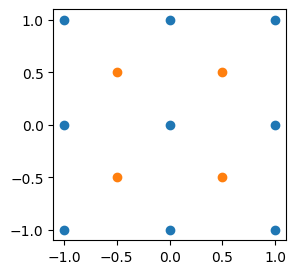

In [11]:
# Adding edge points and inter-points to cover the search space evenly.
center_points, mid_points = generate_grids(n_dims = search_space._dimension.numpy(),
                                           num_points = 3, 
                                           lower_bound=search_space._lower.numpy(),
                                           upper_bound=search_space._upper.numpy())

plt.figure(figsize=(3,3))
plt.scatter(center_points[:, 0], center_points[:, 1], label='center points')
plt.scatter(mid_points[:, 0], mid_points[:, 1], label='mid points')

additional_samples = np.concatenate([center_points, mid_points], axis=0)

In [12]:
def load_mat_files(feature_names: list, mat_files : list[Path|str]):   
    return_data = []
    
    for e, mf in enumerate(mat_files):
        # TODO. probably verify that files have the same length. 
        # If accuracy of sim_time has been changed the files won't match!
        file_path = Path(mf)
        mat_file = io.loadmat(file_path, squeeze_me=True, simplify_cells=True)
        
        save_key = [k for k in mat_file.keys() if not k.startswith("_")]
        save_key = save_key[0]
        mat_file = mat_file[save_key]

        inputs = dict()

        for k in feature_names:
            inputs[k] = mat_file['varin'][k.replace("pulse_parameters_","")]

        data_dict = {'inputs': inputs,
                    'stimulis':mat_file['stimuli'],
                    'observations': mat_file['Yp'],
                    'time':mat_file['ts']
                    }
        
        return_data.append(data_dict)
        
    return return_data

In [13]:
if load_previous_samples:
    mat_files = list(save_path.glob("*.mat"))
    if len(mat_files) == 0:
        msg = f"No files found on {save_path}"
        warnings.warn(msg)
        mat_files = []

        loaded_files = []
        inputs = pd.DataFrame()
    
    else:
        if len(mat_files)> optimizer_config['init_samples']:
            # If there's more data saved than requested initial_samples, let's pick some file at random to initialize
            mat_files = np.random.choice(mat_files, optimizer_config['init_samples'], replace=False)

        loaded_files = load_mat_files(feature_names = feature_names,
                                      mat_files = mat_files)
        inputs = pd.DataFrame([l['inputs'] for l in loaded_files])[feature_names]

else:
    loaded_files = []
    inputs = pd.DataFrame()

In [14]:
# This part of the code will request the initial samples.
# Depending on the computer, this process may take several minutes.
if create_connection:
    server_socket, client_socket = start_connection(connection_config=connection_config,
                                                    problem_config=problem_config)

    handshake_check(client_socket=client_socket, verbose=False)
    msg = {'Fixed_features': fixed_features}
    send_message(client_socket, msg)
    feat_ack = receive_message(client_socket)
    
    if not feat_ack or feat_ack.get("status") != "ready":
        error_msg = f"PYTHON: Did not receive ready signal from CLIENT. Got: {feat_ack}"
        client_socket.close()
        server_socket.close()
        raise ConnectionAbortedError(error_msg)
    
    # If initial samples have been loaded.
    if  len(inputs) < optimizer_config['init_samples']:
        num_samples = optimizer_config['init_samples']- len(inputs)
        mock_sample = False
    else:
        # If loaded samples are sufficient,we query for 1 extra sample in order to test the connection here
        num_samples = 1
        mock_sample = True

    ## Notice that if previous samples are loaded, there's a chance these are redundant due to the Sobol+ seed.
    new_samples = search_space.sample_method(num_samples,
                                             sampling_method='sobol',
                                             seed=42
                                             ).numpy()
    if additional_samples is not None:
        new_samples = np.concatenate([new_samples, 
                                      additional_samples], axis=0)
        
    if scaler:
        new_samples = scaler.inverse_transform(new_samples)
        as_array = new_samples

    new_samples = pd.DataFrame(new_samples, columns=feature_names)
    init_df = pd.concat([inputs, new_samples],axis=0).reset_index(drop=True)

    # We query only for the new samples, as we already have observations for the previously loaded data.
    qp_json = array_to_list_of_dicts(as_array, feature_names)

    response = {'message': 'first queried points using ranom sampling',
                'save_path': str(save_path.resolve()),
                'query_points': qp_json}
    
    response = send_message(client_socket, response)
    received_data = receive_message(client_socket)
    
    file_path = [r['full_observations'] for r in received_data]
    new_files = load_mat_files(feature_names = feature_names,
                                  mat_files = file_path)

    loaded_files.extend(new_files)
    
else:
    server_socket = None
    client_socket = None

Establishing connection at port 127.0.0.0 with port 10005
Waiting for a connection...
Starting MATLAB with Payload:
{'connection_config': {'ip': '127.0.0.0', 'port': 10005, 'Timeout': 30, 'ConnectTimeout': 30, 'target': 'MATLAB'}, 'problem_config': {'experiment_parameters': {'name': 'axonsim_regression', 'type': 'regression', 'fun_type': 'double_pulse', 'pulse_parameters': {'pulse_parameters_I': {'min_value': -2, 'max_value': 2, 'value': 0}, 'pulse_parameters_pulse_dur': {'min_value': 0.1, 'max_value': 2, 'value': 0}}, 'num_electrodes': 1, 'e_pos': [[-1], [-1]], 'c': 0, 'dia': 12, 'e_offset': 0, 'accuracy': 0.01, 'balance_charge': False, 'calc_thr': 0, 'custom_fun': 'stim_sin(t, 20000, 1)', 'e_sep': 0.5, 'e_type': 'single', 'frq': 1, 'length': 40000, 'model_type': 'MRG', 'phi': 35, 'sim_dur': 6}}}
full script path: /home/idlab398/online-neuro/simulators/matlab
Calling Matlab from Python engine...
  struct with fields:

                name: 'axonsim_regression'
                type: 'r

Exception in thread Thread-4 (run_matlab):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/idlab398/online-neuro/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/idlab398/online-neuro/online_neuro/utils/matlab_utils.py", line 97, in run_matlab
    eng.feval(matlab_function_name, matlab_args, nargout=0)
  File "/home/idlab398/online-neuro/.venv/lib/python3.10/site-packages/matlab/engine/matlabengine.py", line 71, in __call__
    _stderr, feval=True).result()
  File "/home/idlab398/online-neuro/.venv/lib/python3.10/site-packages/matlab/engine/futureresult.py", line 67, in result
    return self.__future.result(timeout)
  File "/home/idlab398/online-neuro/.venv/lib/python3.10/site-packages/matlab/engine/fevalfuture.p

Error starting MATLAB: 
  File /home/idlab398/online-neuro/simulators/matlab/utils/receiveMessage.m, line 30, in receiveMessage

  File /home/idlab398/online-neuro/simulators/matlab/main.m, line 217, in main
Error receiving data from the remote server.
Additional Information: Operation timed out before requested data was received.



In [15]:
accuracy = problem_config['experiment_parameters']['accuracy']
sim_time = problem_config['experiment_parameters']['sim_dur']
time_vector = np.linspace(0, sim_time, sim_time*int(1/accuracy))

In [16]:
# Removing duplicated entries (which may occur due to sampling having a fixed seed, or using Sobol)
dups = init_df.duplicated()
remove_ix = init_df[dups].index
loaded_files = [l for e, l in enumerate(loaded_files) if e not in remove_ix]
init_df = init_df.drop_duplicates() #Duplicate sample can appear if files are loaded multiple times.

In [17]:
indexes = np.arange(len(init_df))
test_samples = min (12, int(len(init_df)/2))
SUBSAMPLE_RATE = 4
np.random.shuffle(indexes)
train_ix = indexes[:-test_samples]
test_ix = indexes[-test_samples:]

In [18]:
# We use the init_df, that contains previously seen and newly sampled.
# Concatenate observations and scale (this benefits in most cases the GP
train_df = init_df.iloc[train_ix]
test_df = init_df.iloc[test_ix]

train_obs = np.stack([loaded_files[ix]['observations'] for ix in list(train_ix)])[:,::SUBSAMPLE_RATE, node]

output_scaler = StandardScaler()
output_scaler.fit(train_obs.reshape(-1,1))

eval_train_obs = np.stack([output_scaler.transform(loaded_files[ix]['observations'][:,node].reshape(-1,1)).squeeze() for ix in list(train_ix)])[:,::SUBSAMPLE_RATE]
eval_test_obs = np.stack([output_scaler.transform(loaded_files[ix]['observations'][:,node].reshape(-1,1)).squeeze() for ix in list(test_ix)])[:,::SUBSAMPLE_RATE]

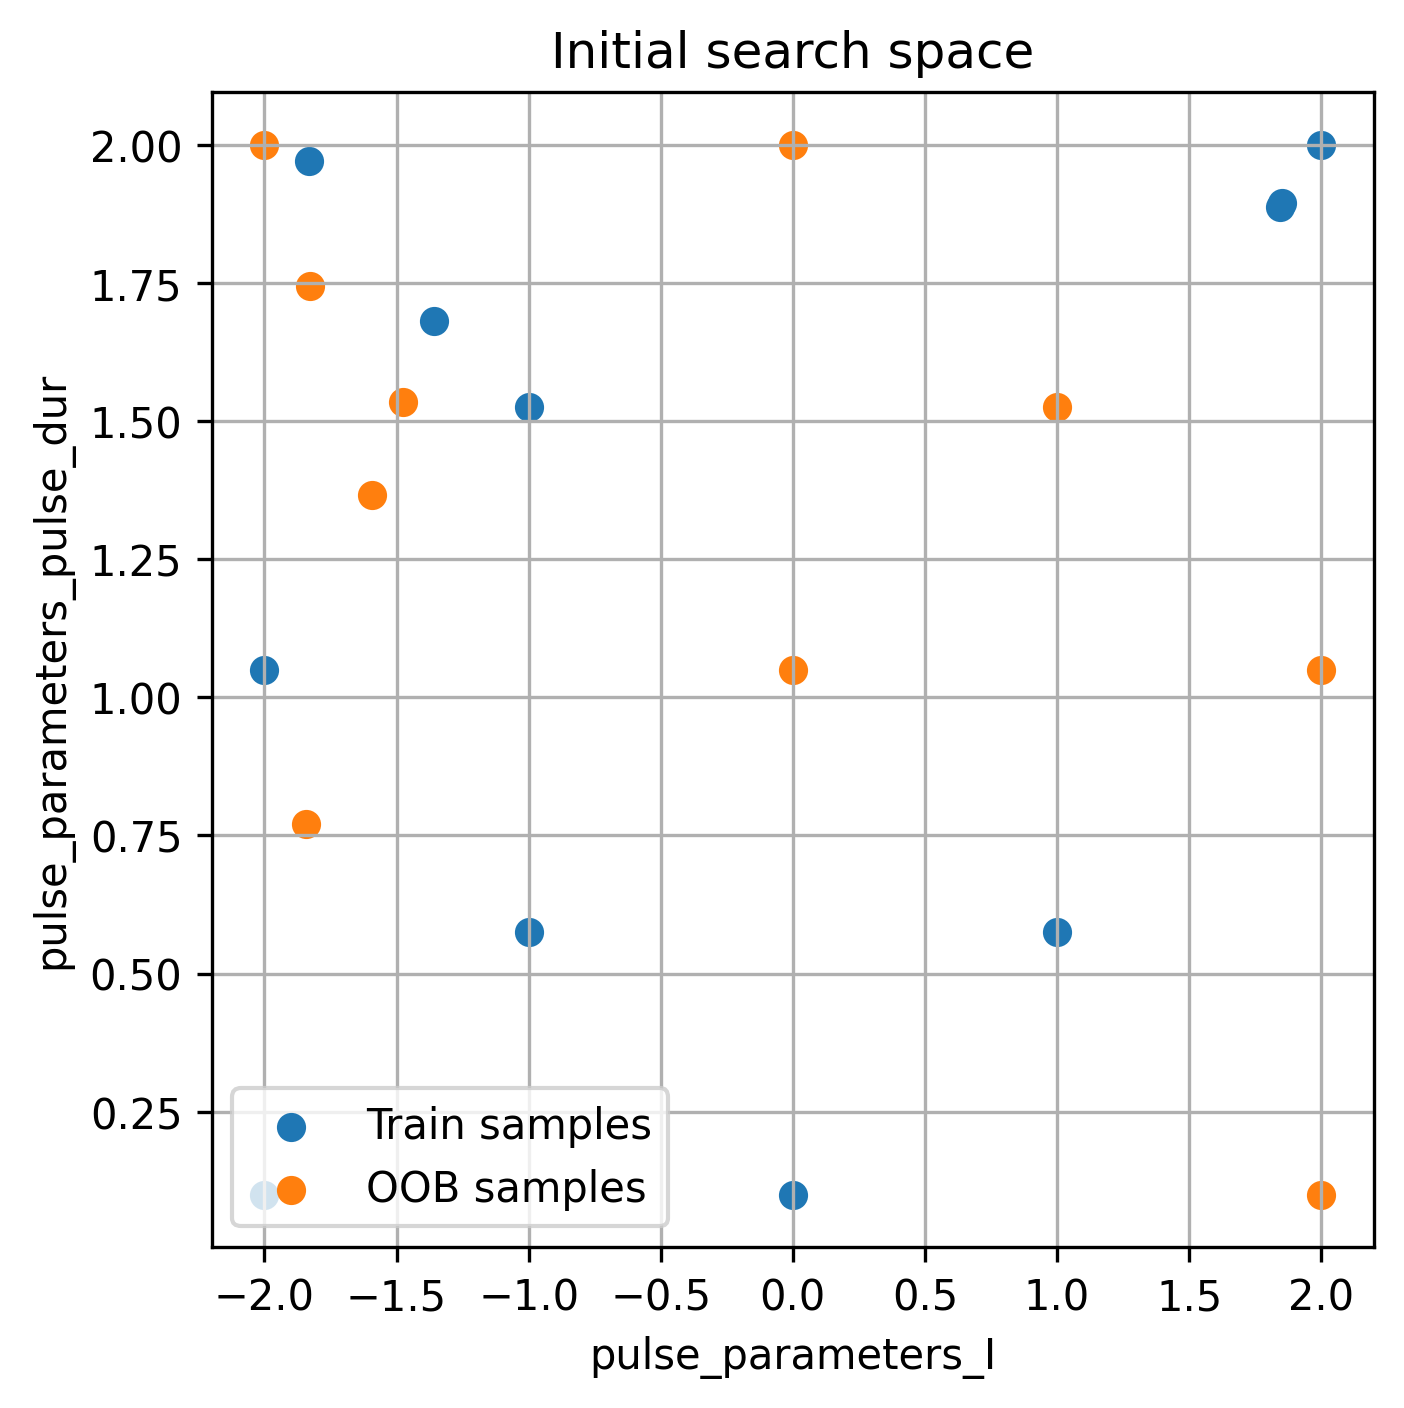

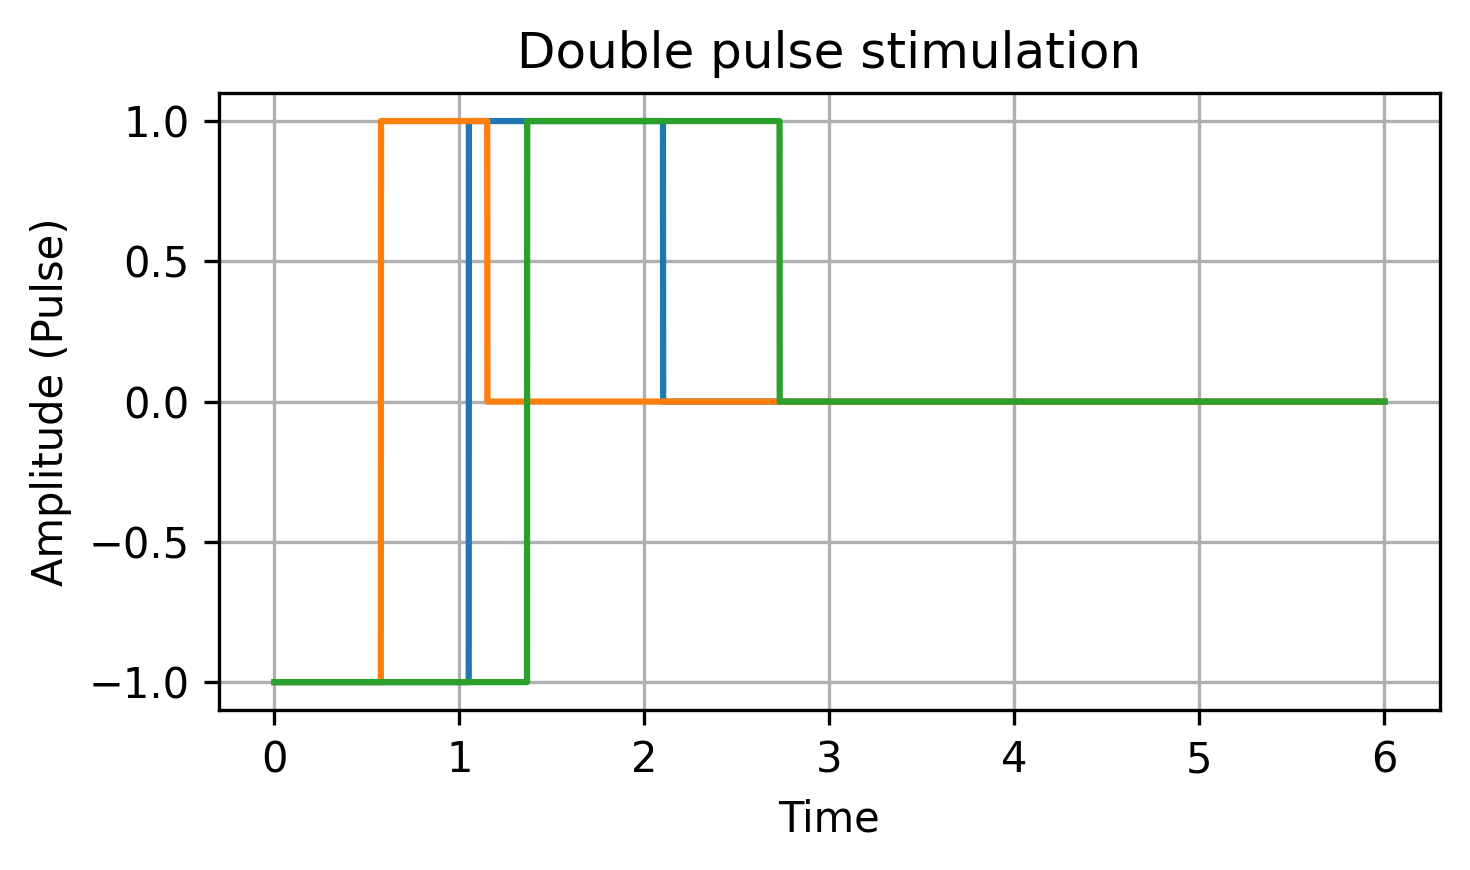

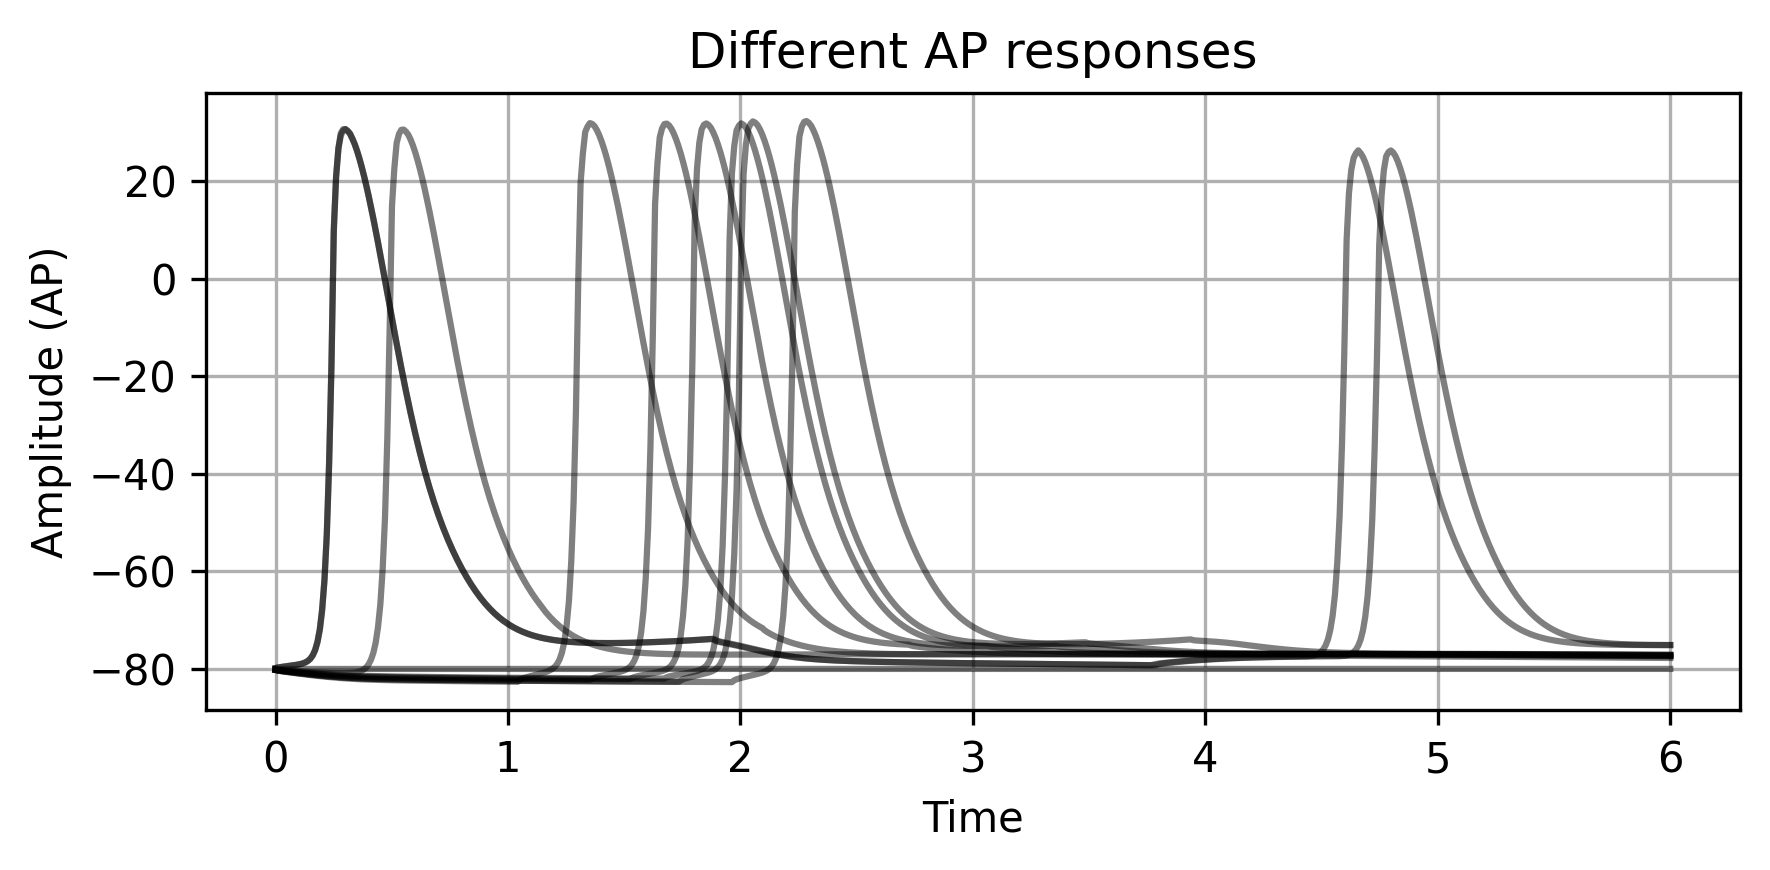

In [19]:
x_axis_label = init_df.columns[0]
y_axis_label = init_df.columns[1]

custom_scatter(
    x_values=[init_df[x_axis_label].values[train_ix], init_df[x_axis_label].values[test_ix]],
    y_values=[init_df[y_axis_label].values[train_ix], init_df[y_axis_label].values[test_ix]],
    labels=['Train samples', 'OOB samples'],
    xlabel=x_axis_label,
    ylabel=y_axis_label,
    title="Initial search space",
    figsize=(5,5),
    dpi=300,
    save_fig=True,
    save_dir=figure_path/"Initial_and_evaluation_samples.svg"
)

fig, ax = plt.subplots(figsize=(5,3), dpi=300)
for s in loaded_files[:3]:
    ax.plot(s['time'], s['stimulis'])
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude (Pulse)")
ax.set_title("Double pulse stimulation")
ax.grid()
fig.tight_layout()
plt.savefig(figure_path/"initial_pulses.svg", format="svg")
plt.show()

fig, ax = plt.subplots(figsize=(6,3), dpi=300)
for o in loaded_files[:10]:
    ax.plot(time_vector, o['observations'][:,-1], c='k', alpha=0.5)
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude (AP)")
ax.set_title("Different AP responses")
ax.grid()
fig.tight_layout()
plt.savefig(figure_path/"ap_responses.svg", format ="svg")
plt.show()



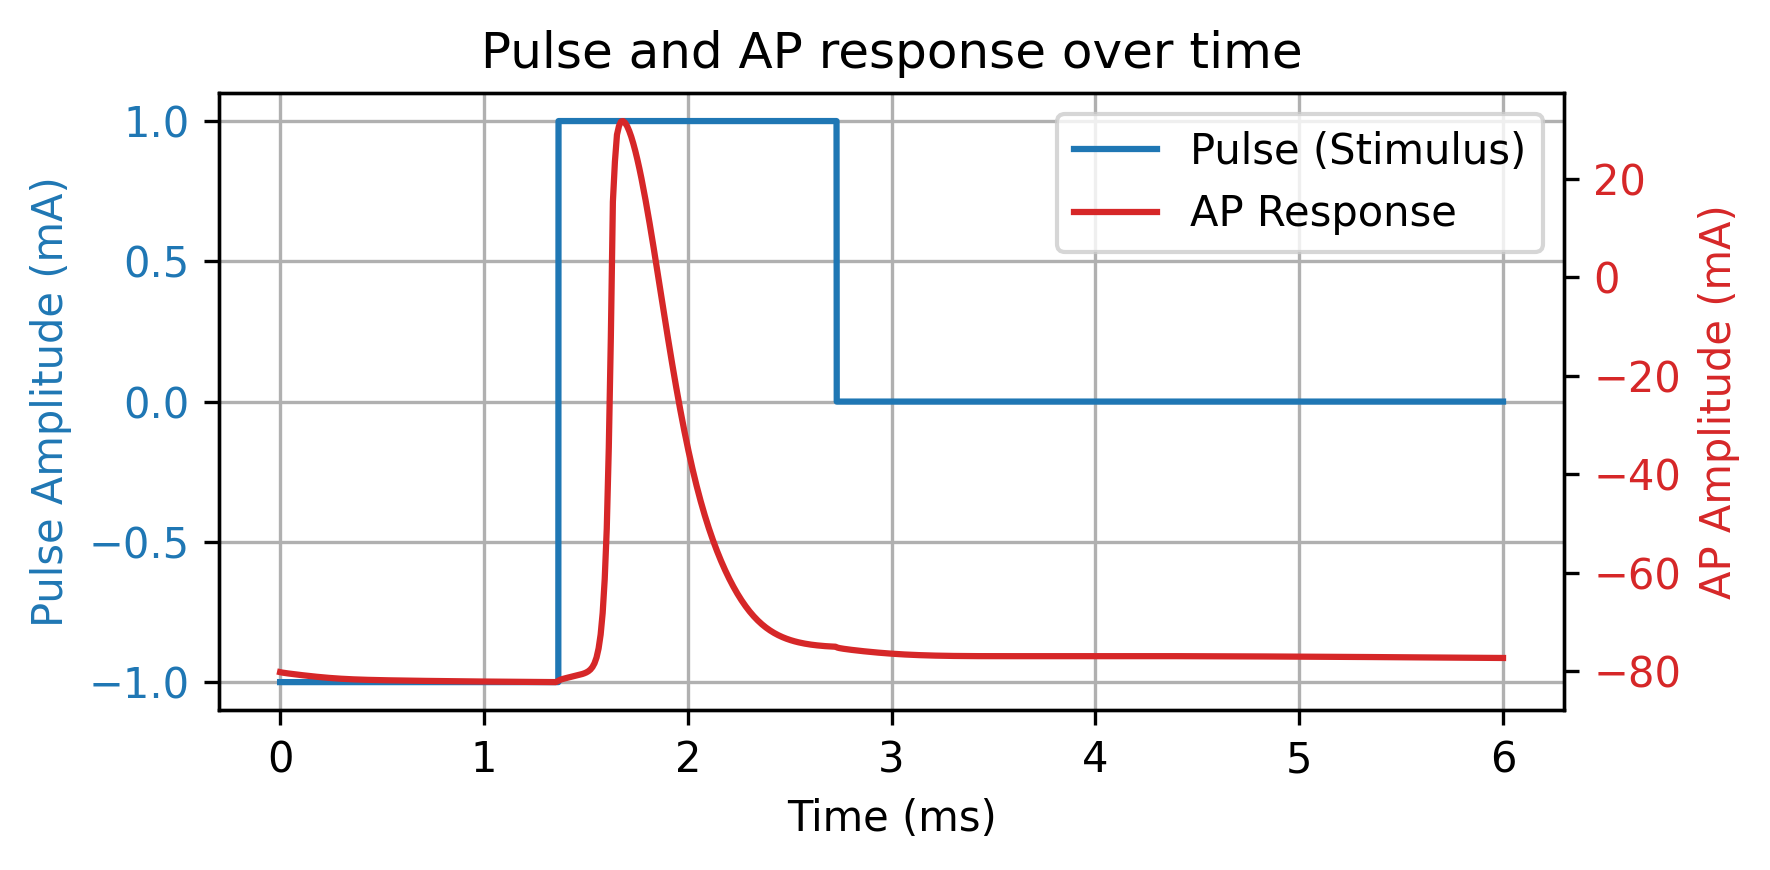

In [20]:
fig, ax1 = plt.subplots(figsize=(6,3), dpi=300)
ix = 2

# Plot stimulus (pulse) on the left y-axis
s = loaded_files[ix]
ln1 = ax1.plot(s['time'], s['stimulis'], color='tab:blue', label="Pulse (Stimulus)")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Pulse Amplitude (mA)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid()

# Create second y-axis
ax2 = ax1.twinx()
o = loaded_files[ix]
ln2 = ax2.plot(time_vector, o['observations'][:,-1], color='tab:red', label="AP Response")
ax2.set_ylabel("AP Amplitude (mA)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Combine legends
lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper right')

ax1.set_title("Pulse and AP response over time")
fig.tight_layout()
plt.savefig(figure_path / "combined_pulse_ap.svg", format="svg")
plt.show()

In [21]:
scaled_trained_df = scaler.transform(train_df)
scaled_test_df = scaler.transform(test_df)

dataset = Dataset(scaled_trained_df, eval_train_obs)
print(dataset.query_points.shape, dataset.observations.shape)

(11, 2) (11, 150)


In [22]:
K.clear_session()

fit_args = {
    "batch_size": 8,
    "epochs": 30,
    "verbose": 0,
    "callbacks" :[
        tf.keras.callbacks.EarlyStopping(
            monitor="loss",
            patience=5,
            restore_best_weights=True,
            min_delta=0.01
        )
    ]
}

optimizer_ensemble = KerasOptimizer(tf.keras.optimizers.Adam(0.001), fit_args)
optimizer_ensemble.loss = "mean_squared_error"
optimizer_ensemble.metrics = ['mean_squared_error']

mc_model = build_keras_mc_dropout(data=dataset,
                                  dropout_rates=0.30,
                                  hidden_layers=[32, 64, 128],
                                  activations='relu',
                                  task_type='multioutput_regression')

dropout_model = MCDropout(mc_model, optimizer_ensemble)


In [ ]:
sampler = TemporalVarianceMovement(alpha=0.10) #We assign 10% of the weight to temporal difference

acq_fun = DiscreteBatchSampling(sample_size=150,
                                sampler=sampler,
                                query_points=1)

bo = AskTellOptimizerHistory(search_space = search_space,
                             datasets = dataset,
                             models = dropout_model,
                             acquisition_rule = acq_fun,
                             fit_model = False,
                             overwrite = True,
                             track_path = model_path
                            )

## Pre-initial fit
Passing some initial data before training for visualization purposes

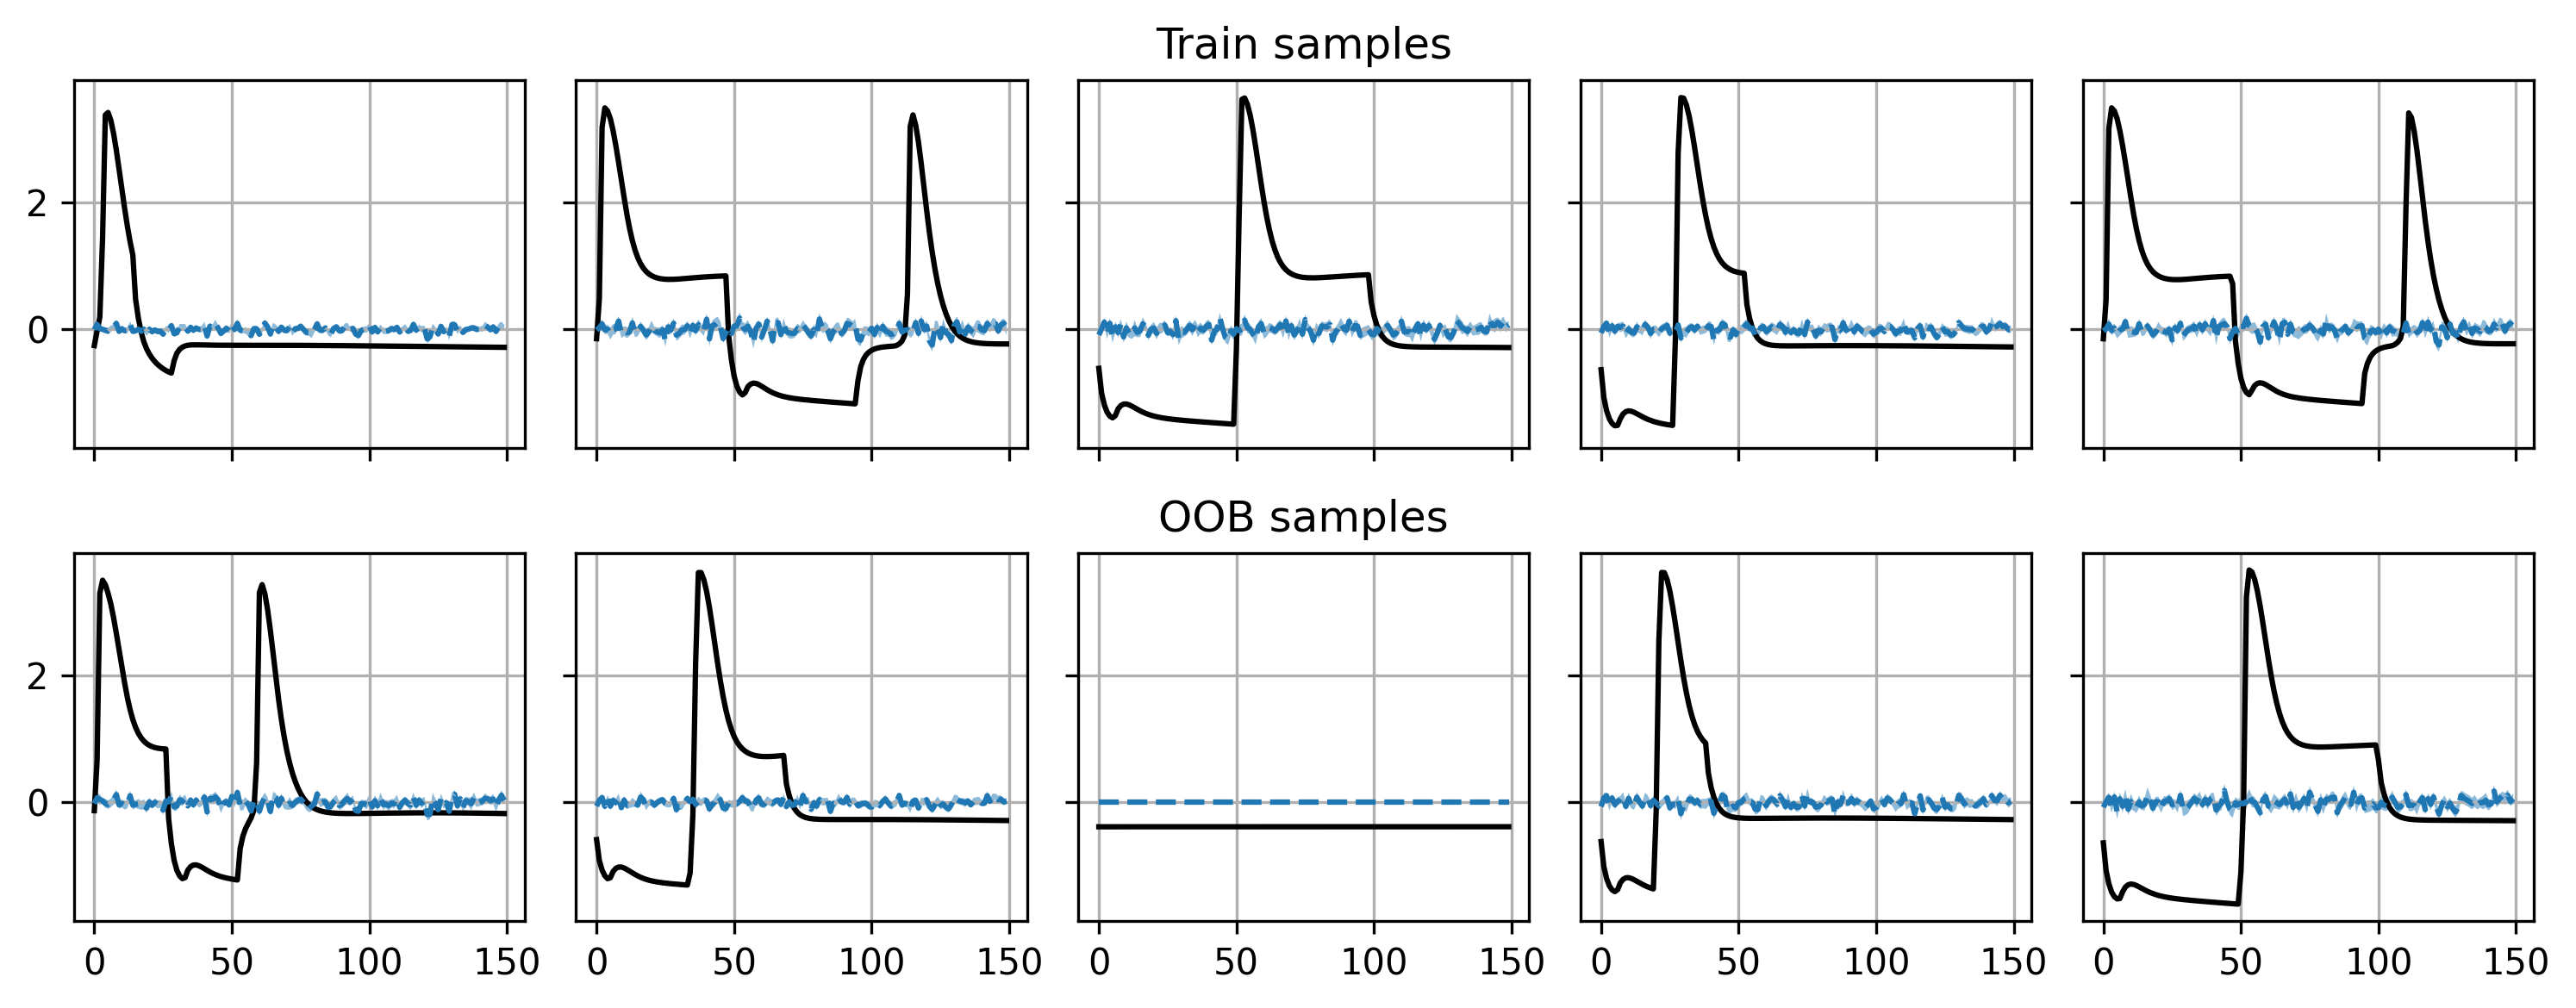

In [24]:
plot_cols = 5
title_ix = int(plot_cols/2)

mean_train, variance_train = bo.models['OBJECTIVE'].predict(scaled_trained_df)
std_train = np.sqrt(variance_train.numpy())

fig, ax = plt.subplots(ncols=plot_cols, nrows=2, figsize=(plot_cols*2,4), dpi=300, sharex=True, sharey=True)
ax = ax.ravel()

# Plot train samples in first row
i = 0
for i in range(plot_cols):
    ax[i].plot(eval_train_obs[i], c='k')
    ax[i].plot(mean_train[i], c='C0', linestyle="--")
    ax[i].fill_between(np.arange(len(mean_train[i])), mean_train[i] - std_train[i], mean_train[i] + std_train[i], interpolate=True, alpha=0.5)
    ax[i].grid()

j = i+1
ax[title_ix].set_title("Train samples")

mean_test, variance_test = bo.models['OBJECTIVE'].predict(scaled_test_df)
std_test = np.sqrt(variance_test.numpy())

# Plot test samples in second row
for i in range(plot_cols):
    ax[j+i].plot(eval_test_obs[i], c='k')
    ax[j+i].plot(mean_test[i], c='C0', linestyle="--")
    ax[j+i].fill_between(np.arange(len(mean_test[i])), mean_test[i] - std_test[i], mean_test[i] + std_test[i], interpolate=True, alpha=0.5)
    ax[j+i].grid()

ax[title_ix+j].set_title("OOB samples")

fig.tight_layout()
plt.savefig(figure_path / "evaluation_before_fit.svg",format='svg')
plt.show()


In [25]:
bo.initial_fit()

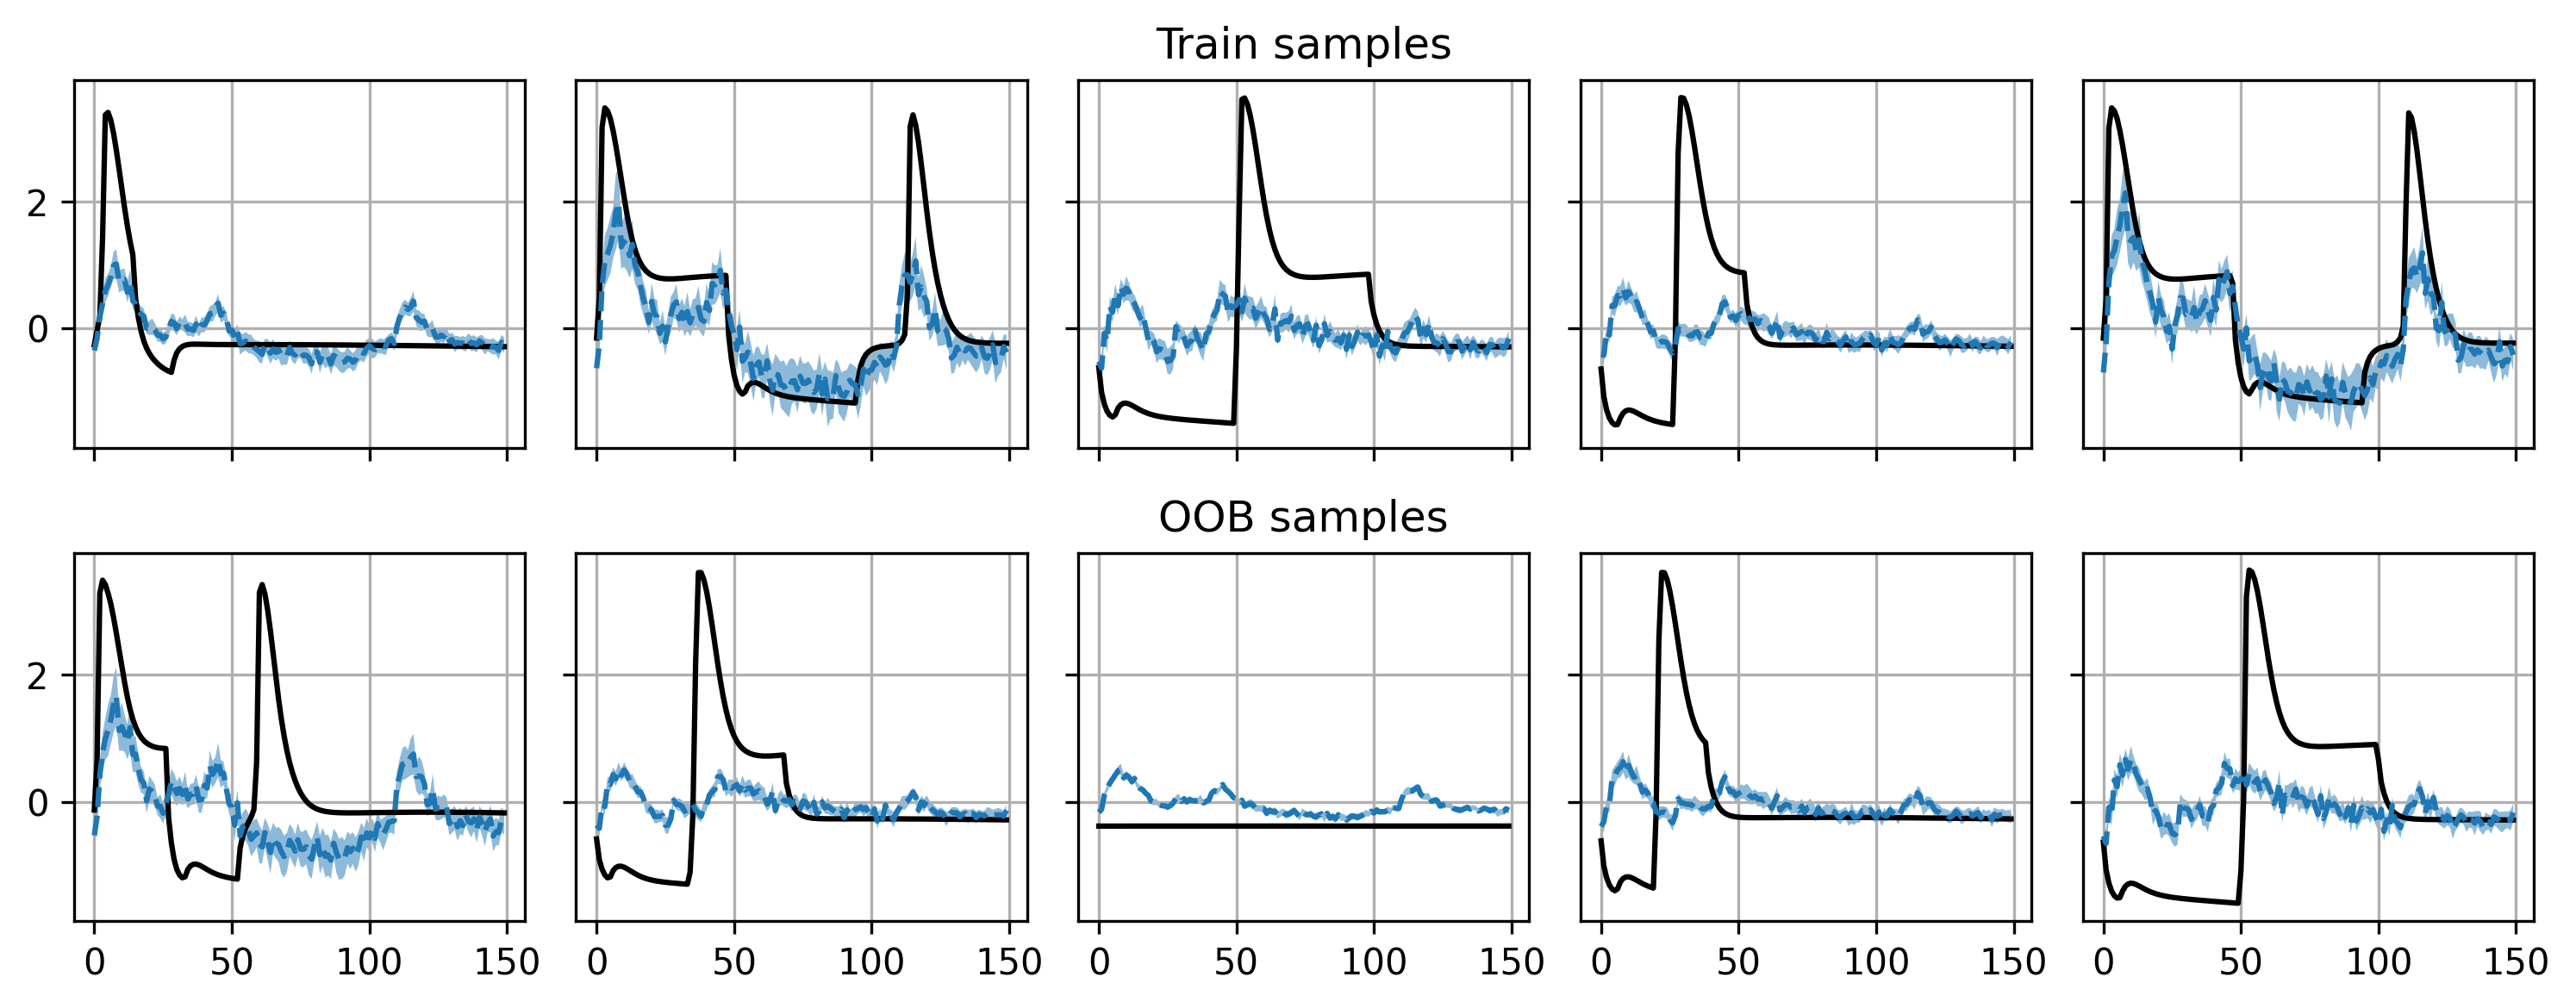

In [26]:
mean_train, variance_train = bo.models['OBJECTIVE'].predict(scaled_trained_df)
std_train = np.sqrt(variance_train.numpy())

fig, ax = plt.subplots(ncols=plot_cols, nrows=2,figsize=(plot_cols*2,4), dpi=300, sharex=True, sharey=True)
ax = ax.ravel()

# Plot train samples in first row
i = 0
for i in range(plot_cols):
    ax[i].plot(eval_train_obs[i], c='k')
    ax[i].plot(mean_train[i], c='C0', linestyle="--")
    ax[i].fill_between(np.arange(len(mean_train[i])), mean_train[i] - std_train[i], mean_train[i] + std_train[i], interpolate=True, alpha=0.5)
    ax[i].grid()

j = i+1
ax[title_ix].set_title("Train samples")

mean_test, variance_test = bo.models['OBJECTIVE'].predict(scaled_test_df)
std_test = np.sqrt(variance_test.numpy())
# Plot test samples in second row
for i in range(plot_cols):
    ax[j+i].plot(eval_test_obs[i], c='k')
    ax[j+i].plot(mean_test[i], c='C0', linestyle="--")
    ax[j+i].fill_between(np.arange(len(mean_test[i])), mean_test[i] - std_test[i], mean_test[i] + std_test[i], interpolate=True, alpha=0.5)
    ax[j+i].grid()

ax[title_ix+j].set_title("OOB samples")

fig.tight_layout()
plt.savefig(figure_path / "evaluation_after_fit.svg",format='svg')
plt.show()

In [27]:
rmse_train = [np.sqrt(np.mean((eval_train_obs[i]-mean_train[i])**2)) for i in range(len(eval_train_obs))] 
rmse_test = [np.sqrt(np.mean((eval_test_obs[i]-mean_test[i])**2)) for i in range(len(eval_test_obs))] 

error_dict = {'train':[rmse_train],
'test': [rmse_test] 
}

In [28]:
#%%capture 
#Using %%capture to prevent the printout from Matlab
MAX_SAMPLES = 100
counter = 0
# If true, it will plot an update of the uncertainty space every iteration.
with_plots = False

while counter < MAX_SAMPLES:
    counter += 1
    print(f" Python: Iteration {counter}")

    qp_orig = bo.ask()
    qp_orig = qp_orig.numpy()
    
    if scaler:
        qp = scaler.inverse_transform(qp_orig)
    else:
        qp = qp_orig

    if with_plots:
        next_pair = qp.reshape(1,-1)
        plot_uncertainty(bo, scaler, figure_path,
                         
                         x_axis_label=init_df.columns[0],
                         y_axis_label=init_df.columns[1],
                         
                         cross_pair=next_pair, figsize=(3,3),
                         dpi = 60
                         )

    qp_json = array_to_list_of_dicts(qp, feature_names)
    message = {'query_points': qp_json}
    
    print(f" Python: Iteration {counter} - SENDING to MATLAB: {message}")
    try:
        #    response = send_message(client_socket, response)
        response = send_message(client_socket, message)
    except Exception as e:
        print(f" Python: Iteration {counter} - ERROR sending to MATLAB: {e}")
        break
    
    print(f" Python: Iteration {counter} - WAITING for data from MATLAB...")
    try:
        #received_data = fetch_data(client_socket)
        received_data = receive_message(client_socket)
    except Exception as e:
        print(f" Python: Iteration {counter} - ERROR fetching data from MATLAB: {e}") 
        break 
    
    file_path = [r['full_observations'] for r in received_data]
    new_files = load_mat_files(feature_names = feature_names,
                               mat_files = file_path)
    
    arr_obs = np.stack([lf['observations'] for lf in new_files])[:,::SUBSAMPLE_RATE,node]
    orig_shape = arr_obs.shape
    scaled_output = output_scaler.fit_transform(arr_obs.reshape(-1,1)).reshape(orig_shape)

    # Save results
    new_sample = pd.DataFrame(qp_orig, columns=feature_names)
    init_df = pd.concat([init_df, new_sample],axis=0).reset_index(drop=True)

    # Updating model
    tagged_output = Dataset(query_points=tf.cast(qp_orig, tf.float64),
                            observations=tf.cast(scaled_output, tf.float64))

    bo.tell(tagged_output)
    
    mean_train, variance_train = bo.models['OBJECTIVE'].predict(scaled_trained_df)
    rmse_train = [np.sqrt(np.mean((eval_train_obs[i]-mean_train[i])**2)) for i in range(len(eval_train_obs))]
    
    mean_test, variance_test = bo.models['OBJECTIVE'].predict(scaled_test_df)
    rmse_test = [np.sqrt(np.mean((eval_test_obs[i]-mean_test[i])**2)) for i in range(len(eval_test_obs))]

    error_dict['train'].append(rmse_train)
    error_dict['test'].append(rmse_test) 

 Python: Iteration 1
 Python: Iteration 1 - SENDING to MATLAB: {'query_points': [{'pulse_parameters_I': 1.665287733078003, 'pulse_parameters_pulse_dur': 1.6377262949943545}]}
 Python: Iteration 1 - WAITING for data from MATLAB...
MATLAB receiveMessage: Header received. Expecting message body of 111 bytes.
MATLAB receiveMessage: Message body received. Attempting to decode JSON...
MATLAB receiveMessage: JSON decoding successful.
requested query points 

feat_struct = 

  struct with fields:

                          name: 'axonsim_regression'
                          type: 'regression'
                      fun_type: 'double_pulse'
              pulse_parameters: [1x1 struct]
                num_electrodes: 1
                         e_pos: [2x1 double]
                             c: 0
                           dia: 12
                      e_offset: 0
                      accuracy: 0.01
                balance_charge: 0
                      calc_thr: 0
                    custom_f

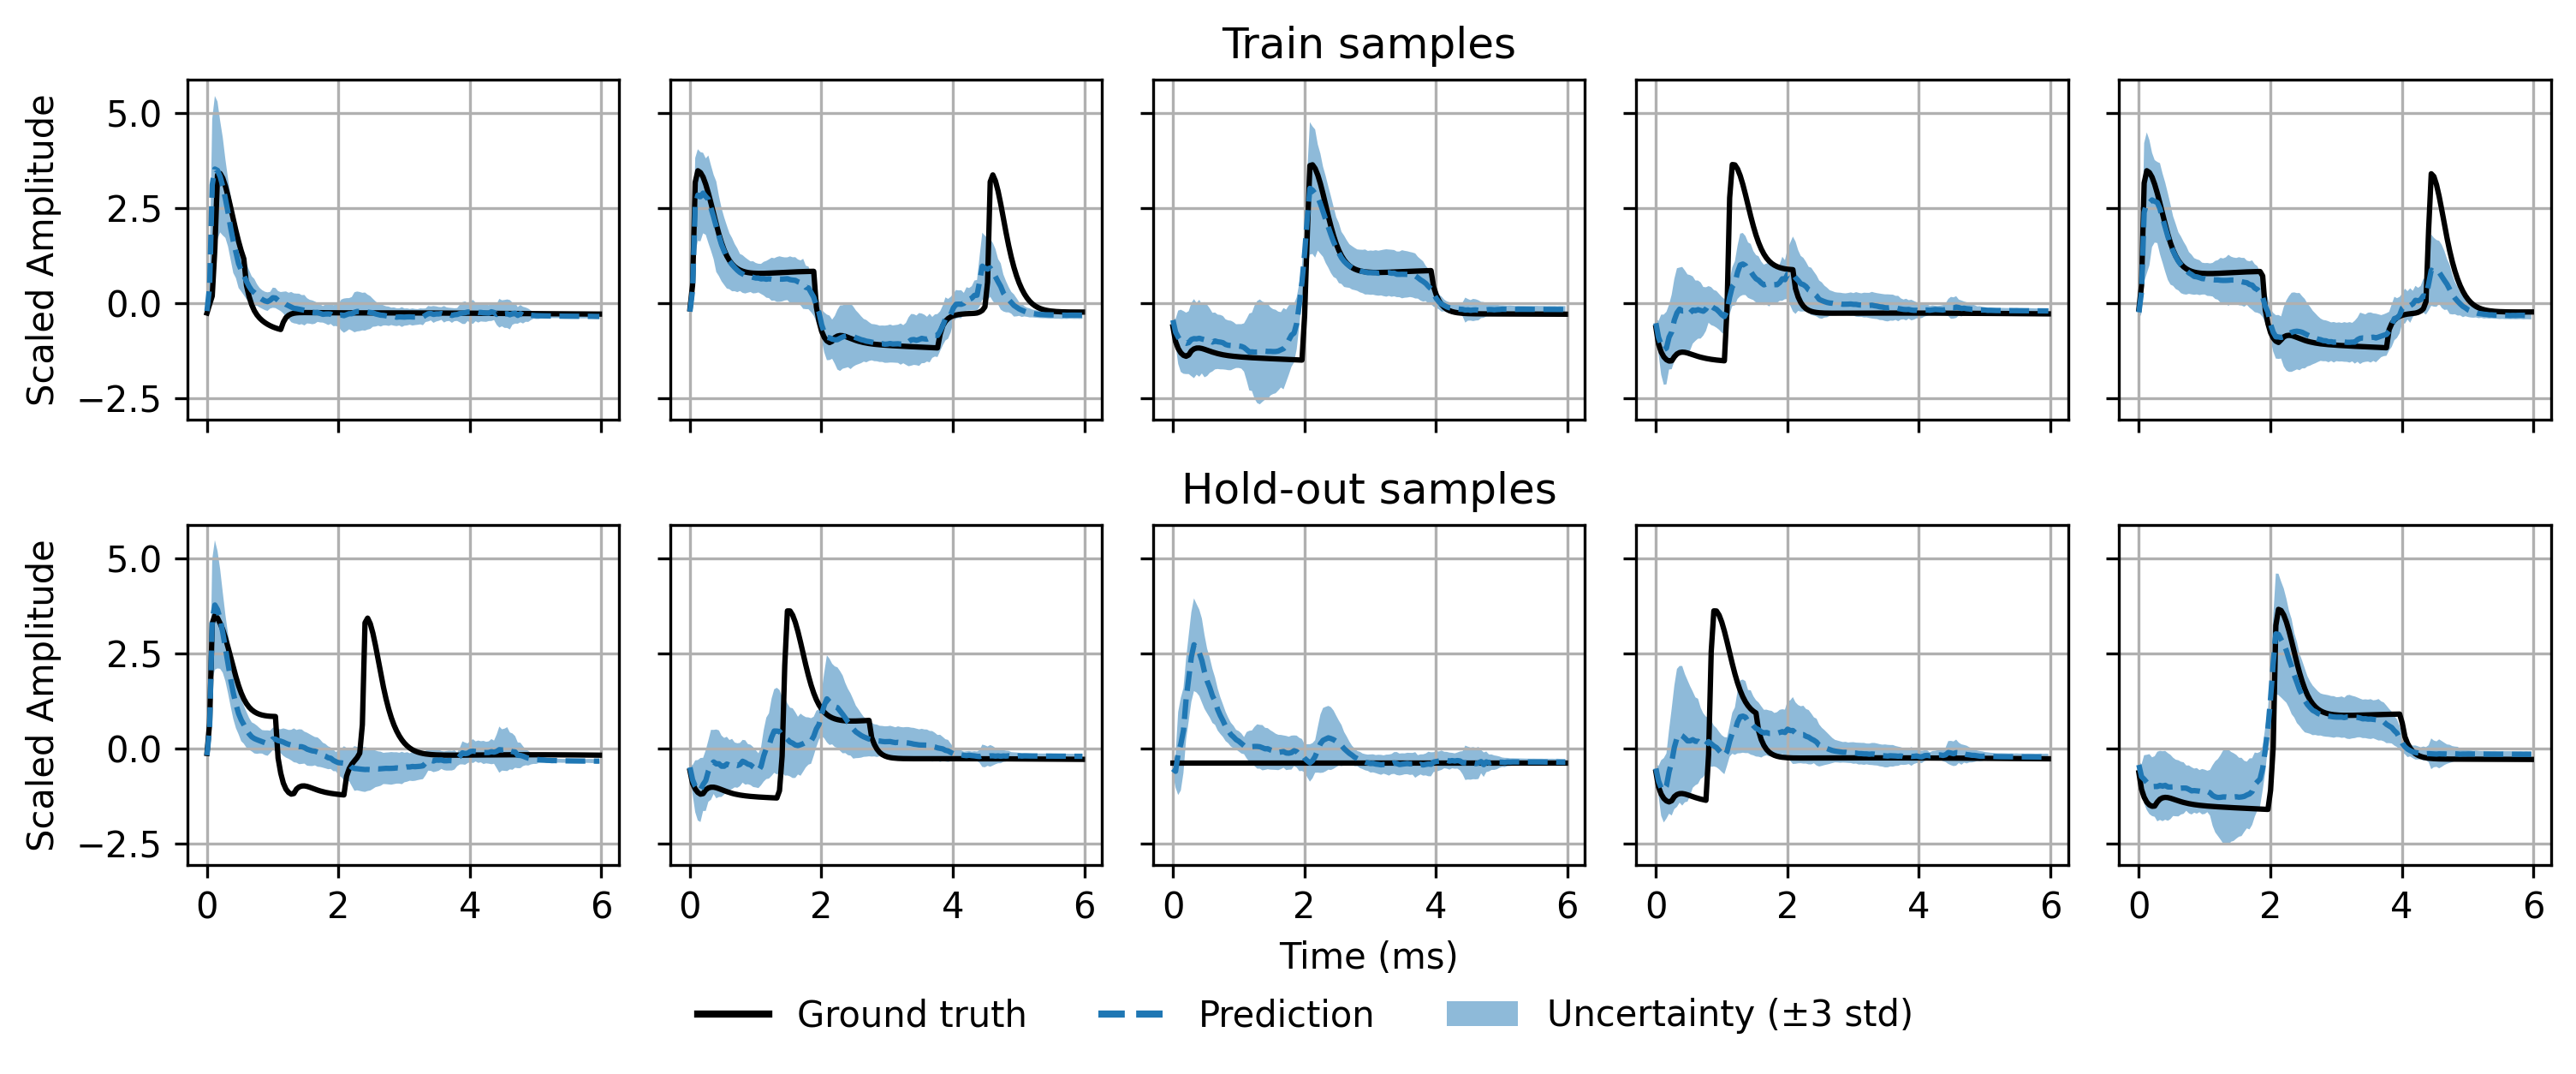

In [29]:
plot_cols = 5
title_ix = 2
num_stds = 3
#bo.models['OBJECTIVE'].predict(scaled_trained_df)
mean_train, variance_train = bo.models['OBJECTIVE'].predict(scaled_trained_df)
std_train = np.sqrt(variance_train.numpy())

fig, ax = plt.subplots(ncols=plot_cols, nrows=2,figsize=(plot_cols*2,4), dpi=300, sharex=True, sharey=True)
ax = ax.ravel()

# Plot train samples in first row
i = 0
for i, ix in enumerate(np.arange(5)):
    ax[i].plot(time_vector[::SUBSAMPLE_RATE], eval_train_obs[ix], c='k')
    ax[i].plot(time_vector[::SUBSAMPLE_RATE],mean_train[ix], c='C0', linestyle="--")
    ax[i].fill_between(time_vector[::SUBSAMPLE_RATE], mean_train[ix] - num_stds * std_train[ix], mean_train[ix] + num_stds * std_train[ix], interpolate=True, alpha=0.5)
    ax[i].grid()

j = i+1
ax[title_ix].set_title("Train samples")

mean_test, variance_test = bo.models['OBJECTIVE'].predict(scaled_test_df)
std_test = np.sqrt(variance_test.numpy())
# Plot test samples in second row
for i, ix in enumerate(np.arange(5)):
    ax[j+i].plot(time_vector[::SUBSAMPLE_RATE], eval_test_obs[ix], c='k')
    ax[j+i].plot(time_vector[::SUBSAMPLE_RATE], mean_test[ix], c='C0', linestyle="--")
    ax[j+i].fill_between(time_vector[::SUBSAMPLE_RATE], mean_test[ix] - num_stds * std_test[ix], mean_test[ix] + num_stds * std_test[ix], interpolate=True, alpha=0.5)
    ax[j+i].grid()

ax[title_ix+j].set_title("Hold-out samples")
ax[0].set_ylabel("Scaled Amplitude")
ax[5].set_ylabel("Scaled Amplitude")
ax[j+title_ix].set_xlabel("Time (ms)")

legend_handles = [
    Line2D([0], [0], color='k', lw=2, label='Ground truth'),
    Line2D([0], [0], color='C0', lw=2, linestyle='--', label='Prediction'),
    Patch(facecolor='C0', alpha=0.5, label=f'Uncertainty (±{num_stds} std)')
]

fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)
)

fig.tight_layout()
plt.savefig(figure_path / "evaluation_after_fit.svg",format='svg')
plt.show()

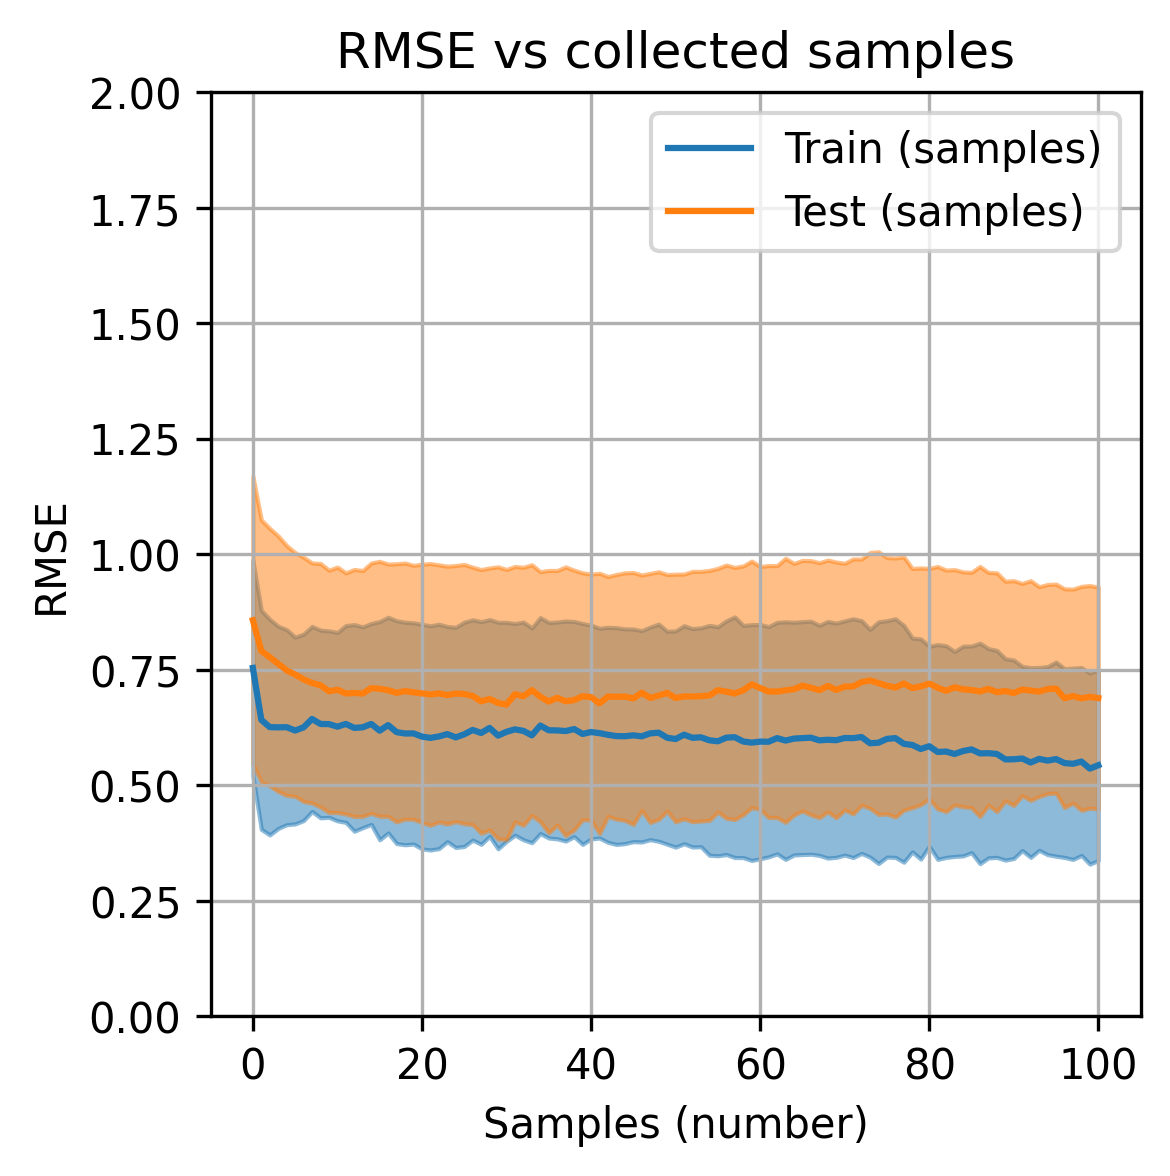

In [30]:
train_mean, train_std = np.stack(error_dict['train']).mean(axis=1), np.stack(error_dict['train']).std(axis=1)
test_mean, test_std = np.stack(error_dict['test']).mean(axis=1), np.stack(error_dict['test']).std(axis=1)

fig, ax = plt.subplots(figsize=(4,4), dpi=300)
ax.plot(train_mean, c='C0', label='Train (samples)')
ax.plot(test_mean, c='C1', label='Test (samples)')
ax.fill_between(np.arange(len(train_mean)),train_mean-train_std, train_mean+train_std,interpolate=True,alpha=0.5,color='C0')
ax.fill_between(np.arange(len(test_mean)),test_mean-test_std, test_mean+test_std,interpolate=True,alpha=0.5,color='C1')
ax.set_title("RMSE vs collected samples")
ax.legend()
ax.set_ylim(0, 2)
#ax.set_xlim(0,30)
ax.grid()
ax.set_xlabel("Samples (number)")
ax.set_ylabel("RMSE")
plt.savefig(figure_path / "rme_over_samples.svg",format='svg')
plt.show()

In [31]:
dataset = bo.dataset
if isinstance(dataset.query_points, np.ndarray):
    X = dataset.query_points
else:
    X = dataset.query_points.numpy()
    
collected_df = scaler.inverse_transform(X)

In [32]:
# fig, ax = plt.subplots(figsize=(3,3),dpi=300)
# x_axis_label = init_df.columns[0]
# y_axis_label = init_df.columns[1]

# ax.scatter(init_df[x_axis_label].values[train_ix], init_df[y_axis_label].values[train_ix], label='Train samples')
# ax.scatter(init_df[x_axis_label].values[test_ix], init_df[y_axis_label].values[test_ix], label='OOB samples' )
# ax.scatter(collected_df[len(indexes):,0], collected_df[len(indexes):,1], label='Collected samples' )
# ax.set_xlabel(x_axis_label)
# ax.set_ylabel(y_axis_label)
# ax.set_title("Explored search space")
# ax.grid()
# plt.legend()
# plt.savefig(figure_path / "search_space(after).svg",format='svg')

# plt.show()

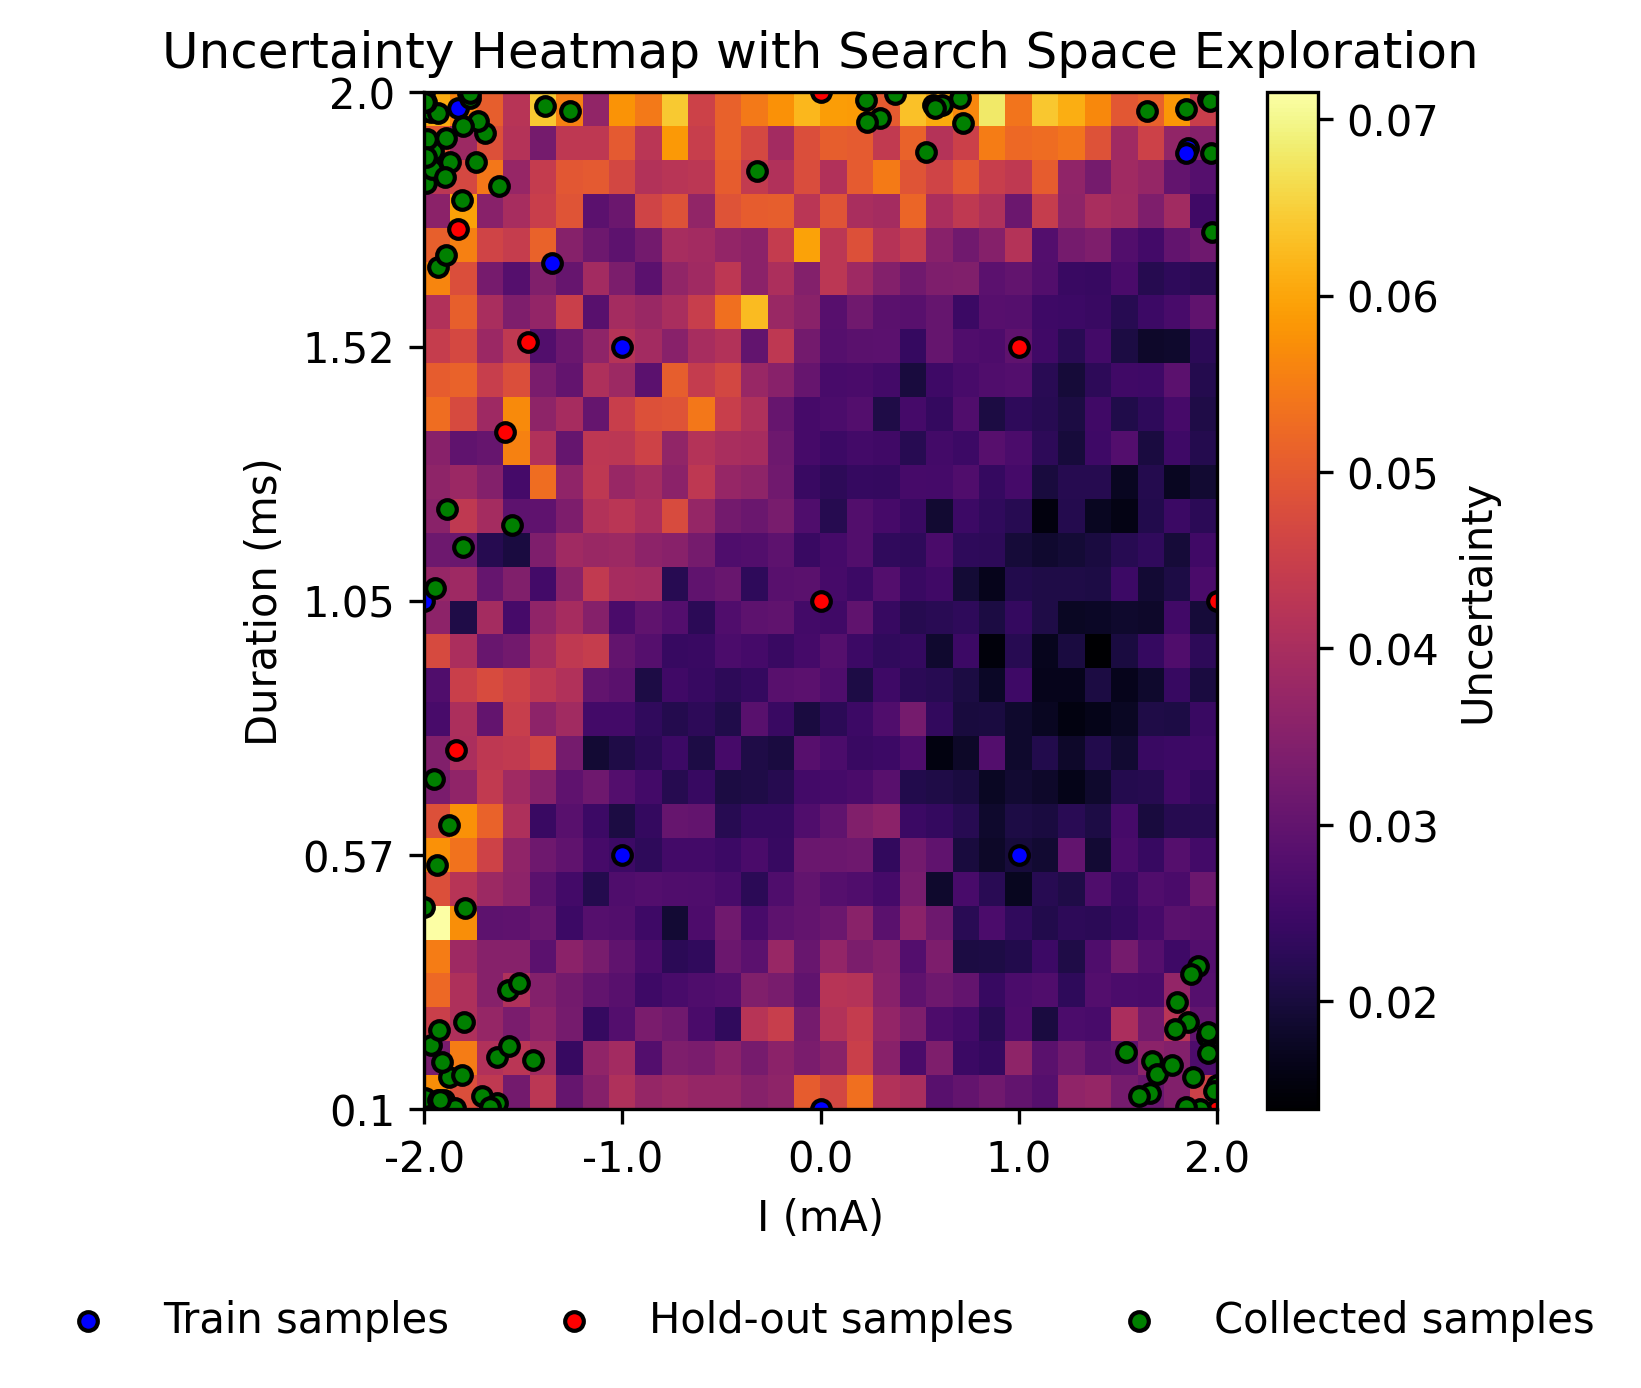

Error using receiveMessage
Error receiving data from the remote server.
Additional Information: Operation timed out before requested data was received.

Error in main (line 217)
            receivedData = receiveMessage(tcpipClient);



MATLAB receiveMessage: An error occurred: Error receiving data from the remote server.
Additional Information: Operation timed out before requested data was received.


In [33]:
plot_uncertainty(bo, scaler, figure_path, 
                 "I (mA)","Duration (ms)", 
                 init_df=init_df, 
                 collected_df=collected_df[len(indexes):],
                 train_ix=train_ix,
                 test_ix=test_ix, dpi=300, figsize=(5,5),
                 s=20)
